### Encoder-decoder-autoreg - Stefano Maxenti - Riccardo Mencucci - "team_durian"

In [ ]:
# The following lines are needed in Gradient Paperspace because these libraries are not installed by default
!pip install scipy sklearn pandas seaborn pillow visualkeras attention

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
from keras import backend as K
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Loading the dataset and taking a look at the data distribution

In [3]:
dataset = pd.read_csv('training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


Load the dataset

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(200,50))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(66528, 7) (2000, 7)


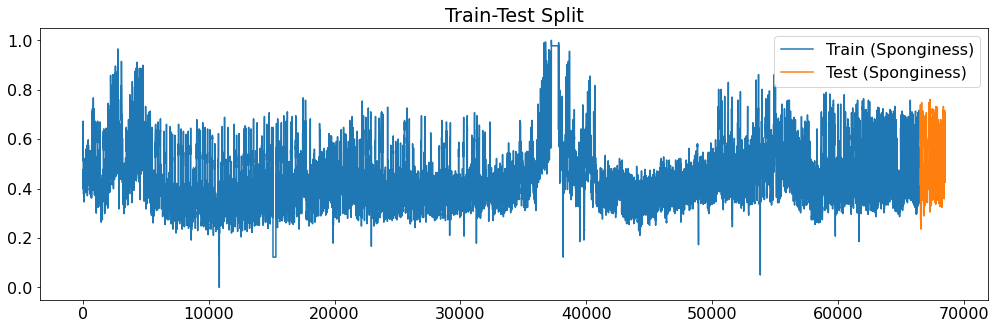

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693


In [5]:
test_size = 2000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()
X_train_raw.head()

In [7]:
window = 300
stride = 1

future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 300, 7)

In [8]:
def build_sequences(df, target_labels=['pollution'], window=400, stride=10, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecasting (Autoregression)

In [9]:
target_labels = dataset.columns
print(target_labels)
telescope = 288

Index(['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact',
       'Meme creativity', 'Soap slipperiness', 'Hype root'],
      dtype='object')


In [10]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66012, 300, 7), (66012, 288, 7), (1512, 300, 7), (1512, 288, 7))

In [11]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(50,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [12]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 150

In [13]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('regression_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

#now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'Encoder-decoder-autoreg'

exp_dir = os.path.join(exps_dir, model_name)# + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_best.ckpt'), 
                                                   save_weights_only=False, save_best_only=True)  # False to save the model directly
#callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
    callbacks.append(es_callback)
callbacks.append(tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, min_lr=1e-7))

In [14]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

# Inspired by code found on Internet
class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

In [15]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true))))#*(X_max-X_min)+X_min)))
def root_mean_squared_error_denorm(y_true, y_pred):
    return K.sqrt(K.mean(K.square(((y_pred*(X_max-X_min)+X_min)) - (y_true*(X_max-X_min)+X_min))))#*(X_max-X_min)+X_min)))
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    model = tfk.Sequential()
    model.add(tfkl.LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Attention())
    model.add(tfkl.Conv1D(128, 100, padding="causal", activation='relu'))
    model.add(tfkl.MaxPool1D())
    model.add(tfkl.LSTM(128, return_sequences=True))
    model.add(tfkl.Conv1D(256, 50, padding="causal", activation='relu'))
    model.add(tfkl.MaxPool1D())
    model.add(tfkl.LSTM(128, return_sequences=True))
    model.add(tfkl.Flatten())
    
    model.add(tfkl.RepeatVector(288))
    model.add(tfkl.LSTM(128, return_sequences=True))
    model.add(tfkl.TimeDistributed(tfkl.Dense(512, activation='relu')))
    model.add(tfkl.Dropout(0.4))
    model.add(tfkl.TimeDistributed(tfkl.Dense(256, activation='relu')))
    model.add(tfkl.Dropout(0.3))
    model.add(tfkl.TimeDistributed(tfkl.Dense(128, activation='relu')))
    model.add(tfkl.Dropout(0.3))
    model.add(tfkl.TimeDistributed(tfkl.Dense(7)))
    # Connect input and output through the Model class
    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(lr=1e-4), metrics=['mae', root_mean_squared_error, root_mean_squared_error_denorm])

    # Return the model
    return model

In [16]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

2022-01-20 14:51:52.823738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 14:51:52.834779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 14:51:52.835723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 14:51:52.837764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 14:51:52.838743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 128)          69632     
_________________________________________________________________
attention (Attention)        (None, 300, 128)          428       
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 128)          1638528   
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 128)          131584    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 256)          1638656   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 256)           0

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    #validation_split=.2,
    validation_data = (X_test, y_test),
    callbacks = callbacks        
).history

Epoch 1/150
1032/1032 [==============================] - 134s 125ms/step - loss: 0.0237 - mae: 0.1154 - root_mean_squared_error: 0.1492 - root_mean_squared_error_denorm: 8.5263 - val_loss: 0.0140 - val_mae: 0.0845 - val_root_mean_squared_error: 0.1175 - val_root_mean_squared_error_denorm: 7.4693
Epoch 2/150
1032/1032 [==============================] - 129s 125ms/step - loss: 0.0149 - mae: 0.0912 - root_mean_squared_error: 0.1218 - root_mean_squared_error_denorm: 7.1773 - val_loss: 0.0149 - val_mae: 0.0917 - val_root_mean_squared_error: 0.1219 - val_root_mean_squared_error_denorm: 7.5182
Epoch 3/150
1032/1032 [==============================] - 130s 126ms/step - loss: 0.0135 - mae: 0.0859 - root_mean_squared_error: 0.1161 - root_mean_squared_error_denorm: 6.8999 - val_loss: 0.0151 - val_mae: 0.0901 - val_root_mean_squared_error: 0.1223 - val_root_mean_squared_error_denorm: 7.4728
Epoch 4/150
1032/1032 [==============================] - 129s 125ms/step - loss: 0.0127 - mae: 0.0830 - root_

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test[:,:864,:].flatten(),predictions[:,:864,:].flatten())
mean_absolute_error = tfk.metrics.mae(y_test[:,:864,:].flatten(),predictions[:,:864,:].flatten())
print(mean_squared_error, mean_absolute_error)
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
print(mean_squared_error, mean_absolute_error)

(1512, 288, 7)
tf.Tensor(0.007616165, shape=(), dtype=float32) tf.Tensor(0.061792485, shape=(), dtype=float32)
tf.Tensor(0.007616165, shape=(), dtype=float32) tf.Tensor(0.061792485, shape=(), dtype=float32)


In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(50,30))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()


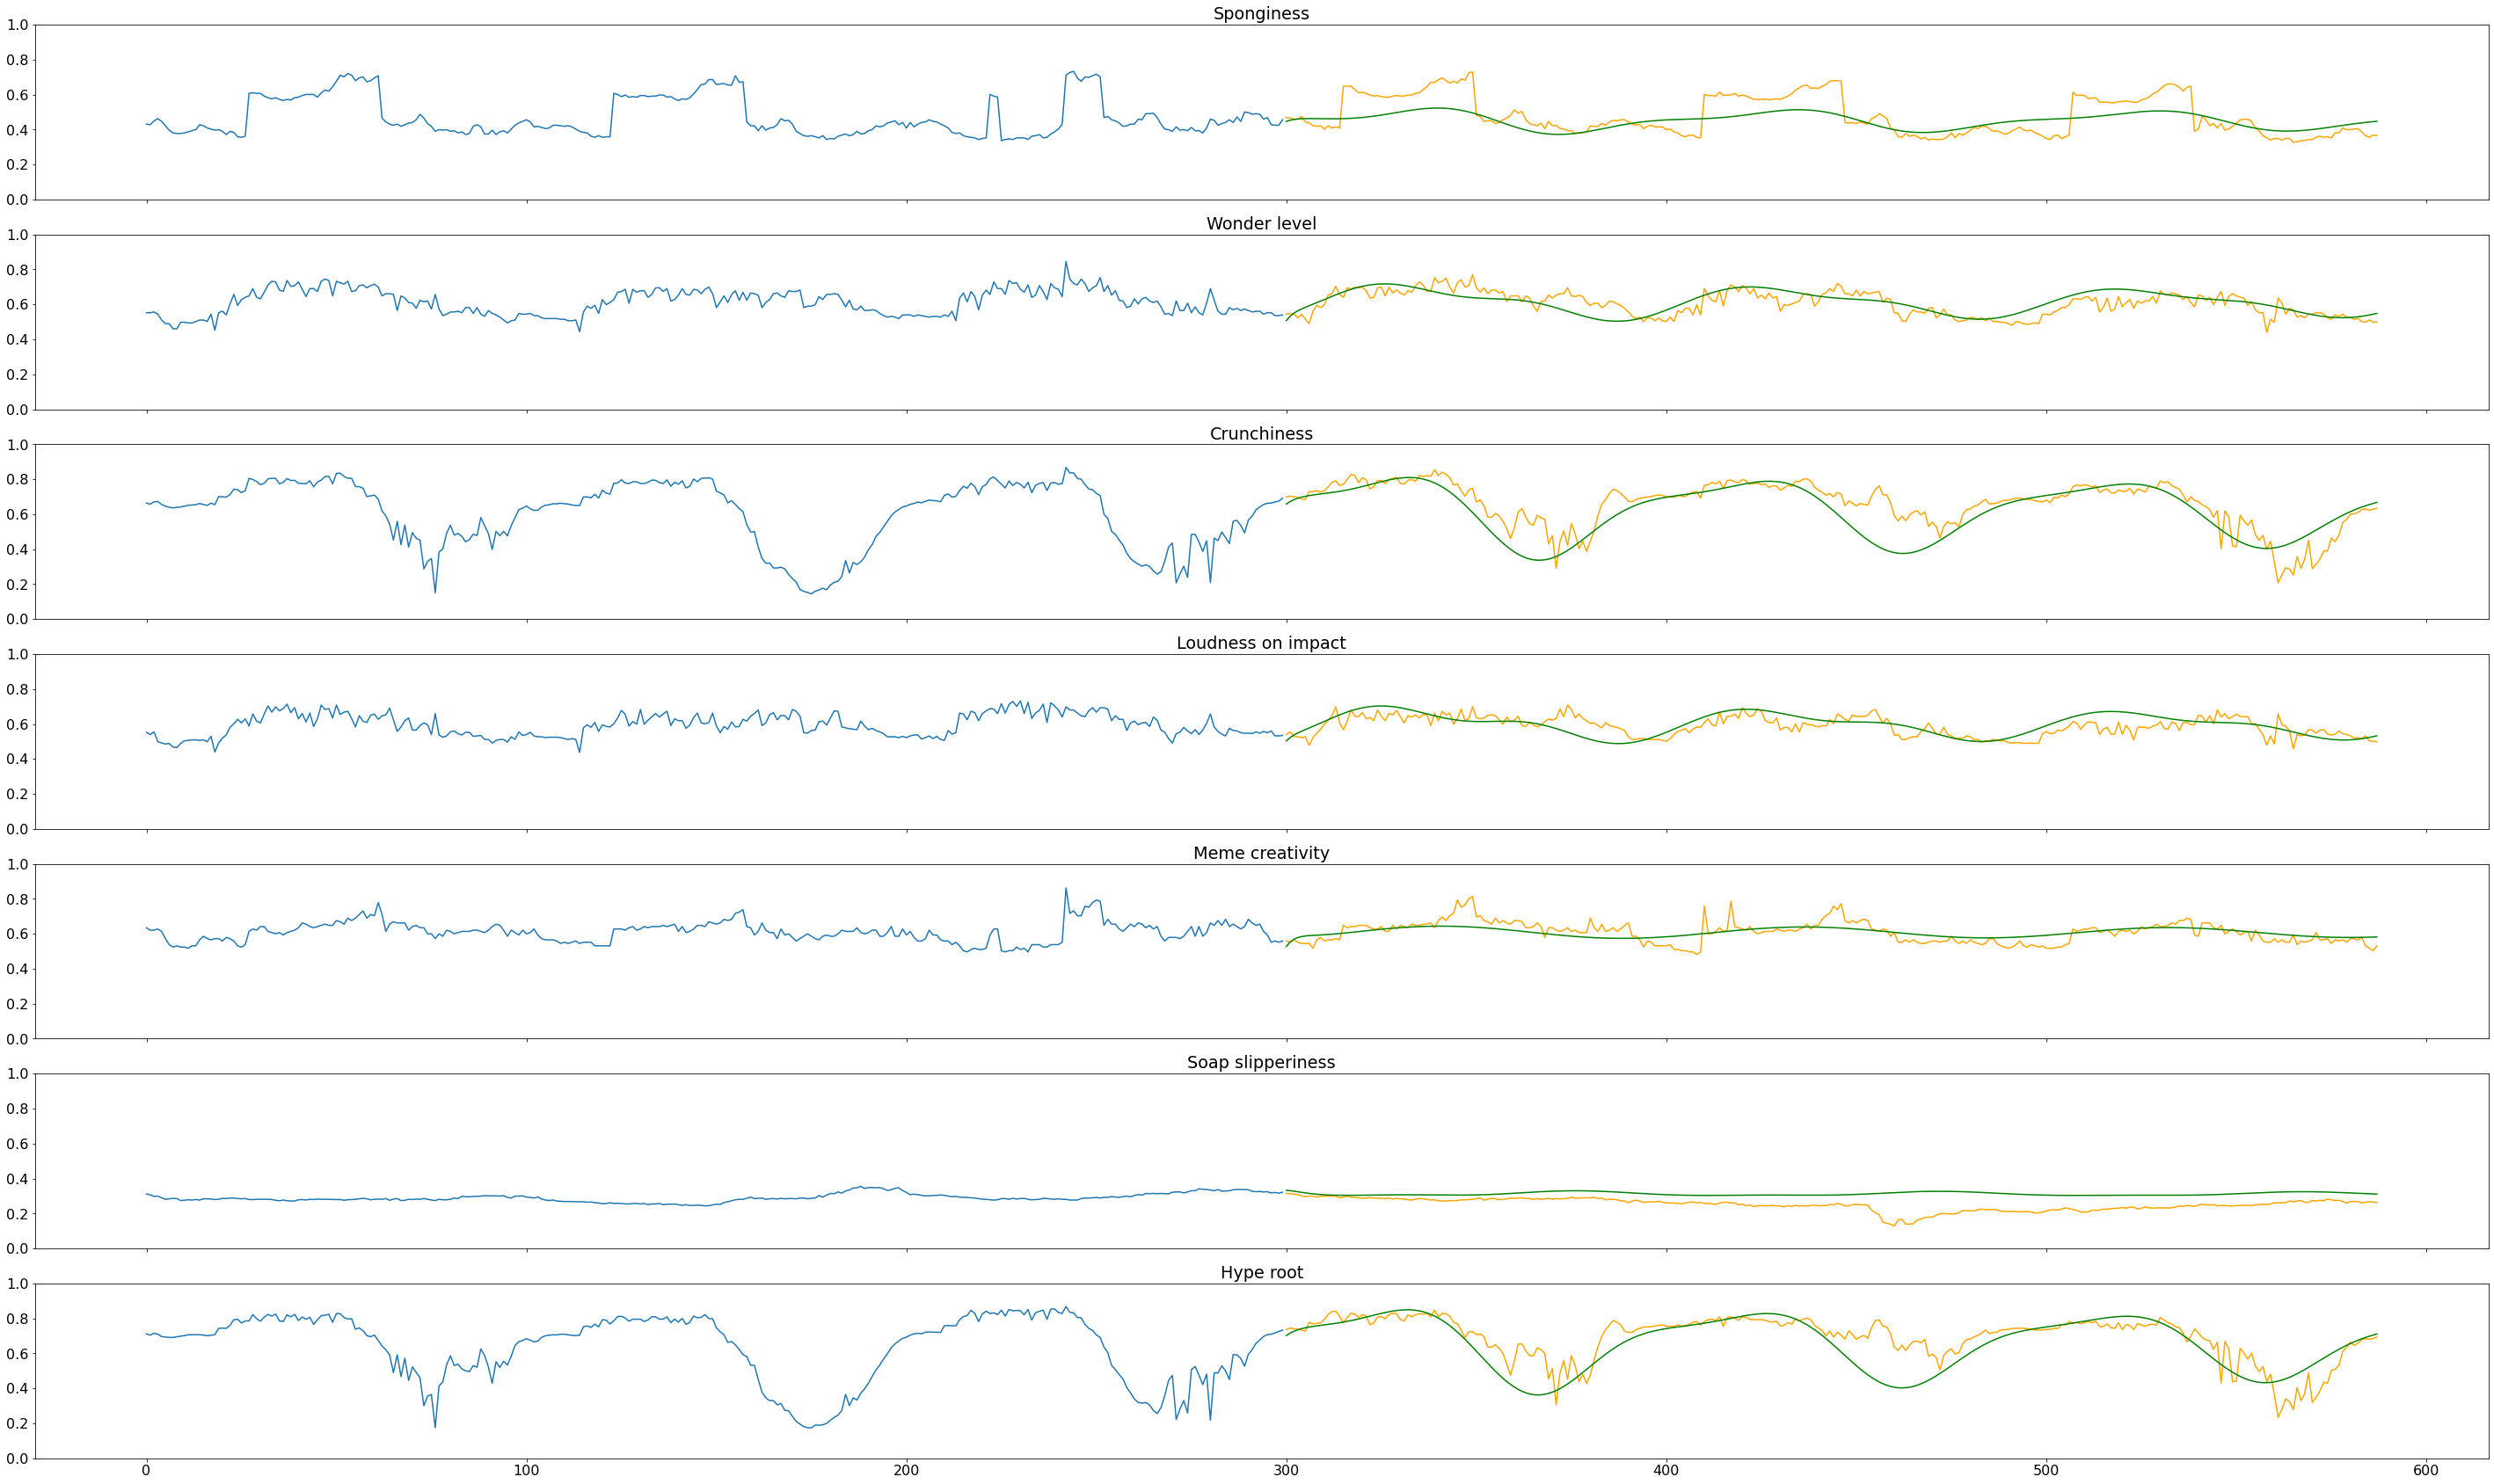

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [ ]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((936, 300, 7), (936, 864, 7))

In [ ]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    print(reg, end= " ")
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

0 288 576 

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg[:,:864,:].flatten(),reg_predictions[:,:864,:].flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg[:,:864,:].flatten(),reg_predictions[:,:864,:].flatten())
print(mean_squared_error, mean_absolute_error)
mean_squared_error = tfk.metrics.mse(y_test_reg[:,:1152,:].flatten(),reg_predictions[:,:1152,:].flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg[:,:1152,:].flatten(),reg_predictions[:,:1152,:].flatten())
print(mean_squared_error, mean_absolute_error)

tf.Tensor(0.008724528, shape=(), dtype=float32) tf.Tensor(0.06870778, shape=(), dtype=float32)
tf.Tensor(0.008724528, shape=(), dtype=float32) tf.Tensor(0.06870778, shape=(), dtype=float32)


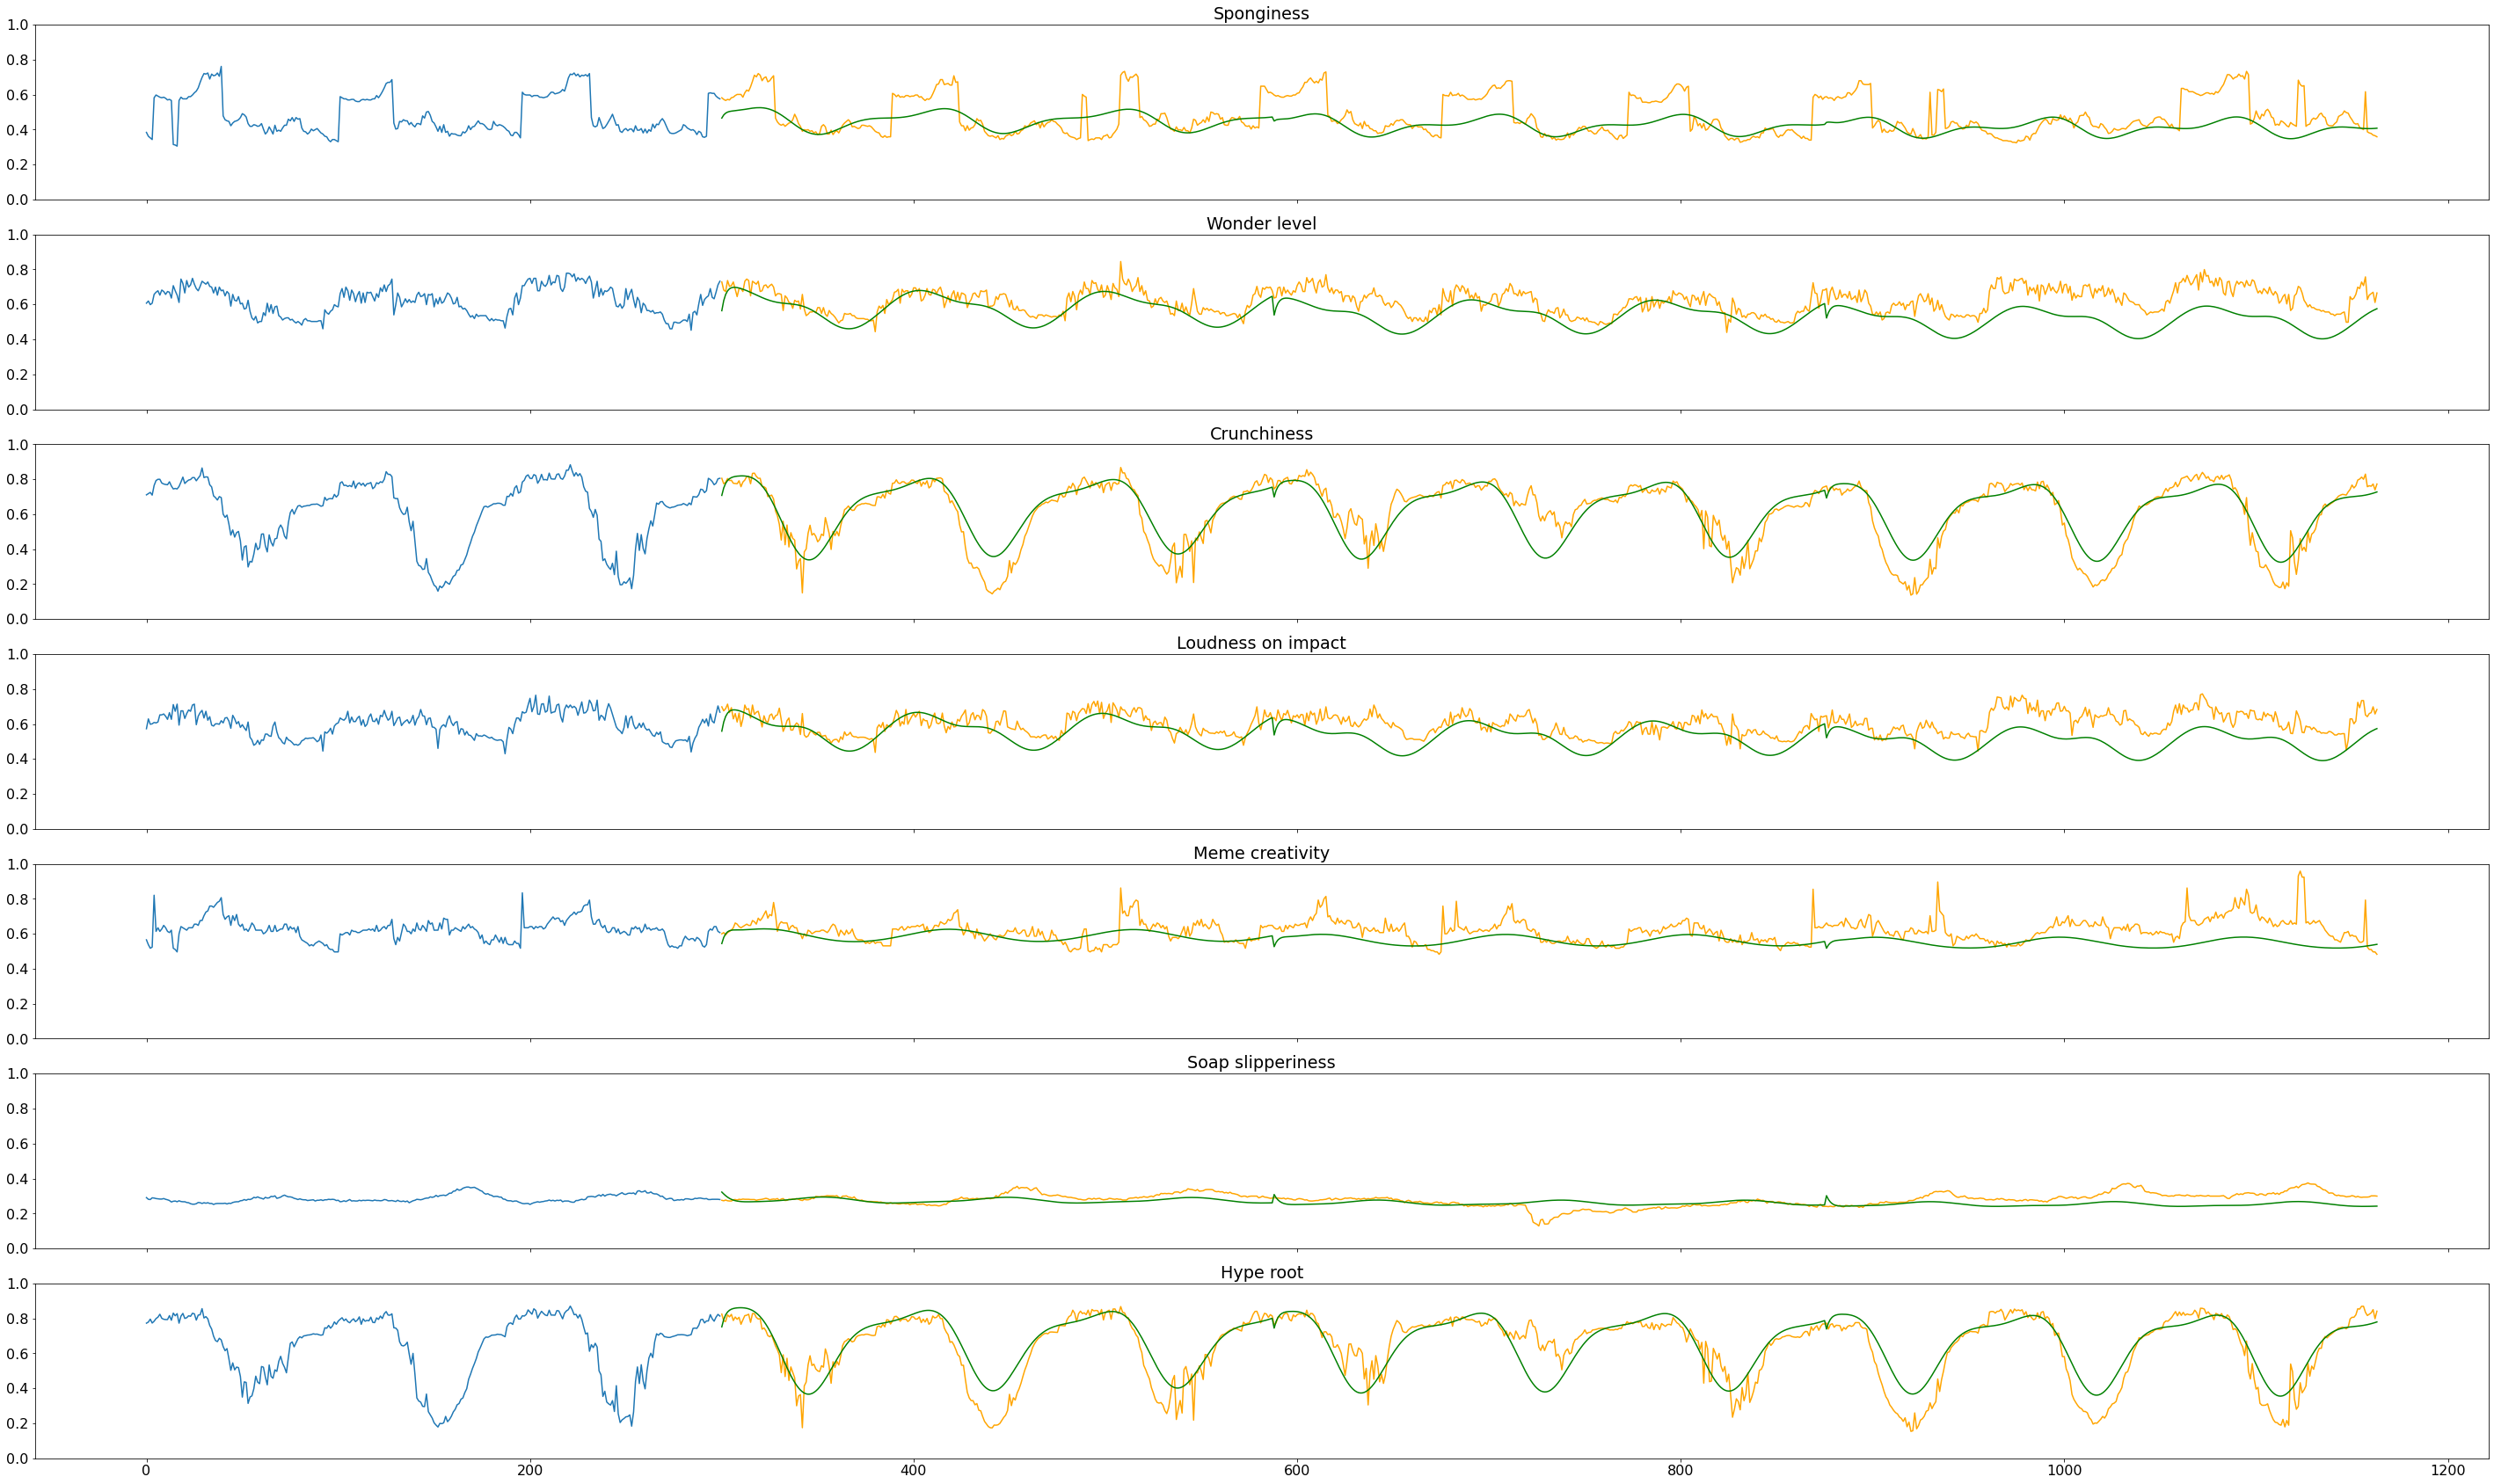

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)